## `Speculator`: NMF-based SFH with burst.

`speculator` takes physical parameters and predict PCA coeffs (see `PCA_components_NMF.ipynb`), spectra, and also magnitudes. 

This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import torch
from torch import Tensor
from scipy.stats import norm

In [3]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator

In [18]:
# kuaizi: under master branch
import kuaizi
kuaizi.set_matplotlib(style='JL', usetex=True)

Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index

(10 params)

### Validate combined emulators

In [4]:
params = np.load(f'./train_sed_NMF/nmf_seds/fsps.NMF.v0.2.theta_unt.seedtest.npy')
params = params[:, 1:]
# exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
print('Number of samples:', params.shape[0])

Number of samples: 100000


In [5]:
# slow
fspecs = [f'./train_sed_NMF/nmf_seds/fsps.NMF.v0.2.log10spectrum.seedtest.npy']
logspec = np.load(fspecs[0])
logspec = logspec.astype('float32')
logspec = logspec[:, wave > 2000]

wave = wave[wave > 2000]

In [6]:
from popsed.speculator import SuperSpeculator

In [7]:
superspec = SuperSpeculator(
    speculators_dir=[f'./speculator_best_loss_model_NMF.emu_{i_bin}.pkl' for i_bin in range(1, 5)], 
    str_wbin=['.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'], 
    wavelength=wave)

In [8]:
_specs = superspec.predict_spec(params,
                                log_stellar_mass=None, 
                                redshift=None).cpu().detach().numpy()

In [14]:
diff = (10**logspec - _specs) / 10**logspec * 100

In [15]:
med_diff = np.median(diff, axis=0)
diff_1sigma = [np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.percentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.percentile(diff, norm.cdf(2) * 100, axis=0)]

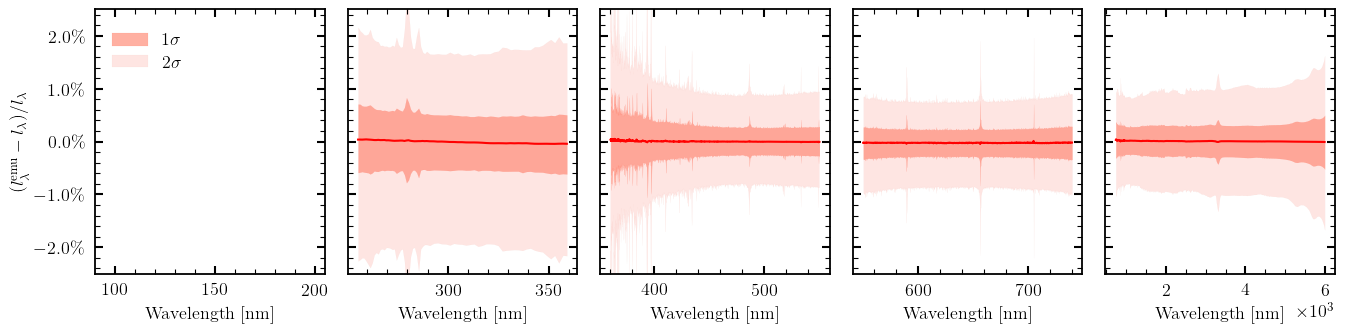

In [23]:
import matplotlib.ticker as mtick
fig, axes = plt.subplots(1, 5, figsize=(16, 3.5), sharey=True)

for i_bin in range(5):
    plt.sca(axes[i_bin])
    wave_bin = [ 
            (wave >= 1000) & (wave < 2000), 
            (wave >= 2000) & (wave < 3600), 
            (wave >= 3600) & (wave < 5500), 
            (wave >= 5500) & (wave < 7410), 
            (wave >= 7410) & (wave < 60000)
            ][i_bin]
    x = wave[wave_bin] / 10
    plt.plot(x, med_diff[wave_bin], color='r')
    plt.fill_between(x, 
                     diff_1sigma[0][wave_bin], 
                     diff_1sigma[1][wave_bin], 
                     alpha=0.5, lw=0.1, color='tomato', label='$1\sigma$')

    plt.fill_between(x, 
                     diff_2sigma[0][wave_bin], 
                     diff_2sigma[1][wave_bin], 
                     alpha=0.2, lw=0.1, color='salmon', label='$2\sigma$')
    plt.xlabel('Wavelength [nm]')
    plt.ylim(-2.5, 2.5)
    
axes[0].set_ylabel(r'$(l_{\lambda}^{\mathrm{emu}} - l_{\lambda})/l_{\lambda}$')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[0].legend(loc='upper left', bbox_to_anchor=(-0.03, 1.))
axes[0].set_xlim(90, 205)

plt.savefig('/home/jiaxuanl/Research/popsed/figure/emulator_accuracy.png')

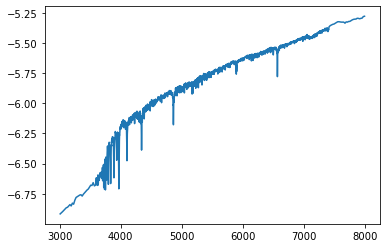

In [18]:
specs = torch.log10(superspec.predict_spec(params[:10], 
                       log_stellar_mass=torch.ones(10, 1).to('cuda') * 10, 
                       redshift=torch.zeros(10, 1).to('cuda') * 0.01))
flag = (superspec.wavelength < 8000) & (superspec.wavelength > 3000)
specs = specs[:, flag].cpu().detach().numpy()
plt.plot(superspec.wavelength[flag].cpu().numpy(), specs[5])

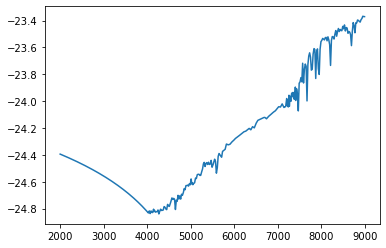

In [32]:
specs = torch.log10(superspec.predict_spec(params[:10], 
                       log_stellar_mass=torch.ones(10, 1).to('cuda') * 10, 
                       redshift=torch.ones(10, 1).to('cuda') * 1))
# flag = (superspec.wavelength < 8000) & (superspec.wavelength > 3000)
# specs = specs[:, flag].cpu().detach().numpy()
# plt.plot(superspec.wavelength[flag].cpu().numpy(), specs[5])

flag = (superspec.wavelength < 9000)
specs = specs[:, flag].cpu().detach().numpy()
plt.plot(superspec.wavelength[flag].cpu().numpy(), specs[5])

In [28]:
# diff = (10**logspec[val_ind] - _specs) / 10**logspec[val_ind] * 100
# diff = np.abs(10**logspec - _specs) / 10**logspec * 100
diff = np.abs(10**logspec - 10**_logspecs) / 10**logspec# * 100
# diff = (10**logspec - _specs) / 10**logspec* 100
# diff = (logspec[val_ind] - np.log10(_specs)) / logspec[val_ind] * 100

Text(0.5, 0, 'Wavelength [nm]')

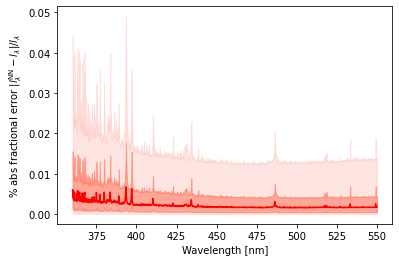

In [29]:
x = wave[wave_bin] / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

plt.ylabel(r'% abs fractional error $|l_{\lambda}^{\mathrm{NN}} - l_{\lambda}|/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

# plt.xscale('log')
# plt.ylim(0, 0.05)

In [30]:
diff = (10**logspec - 10**_logspecs) / 10**logspec* 100

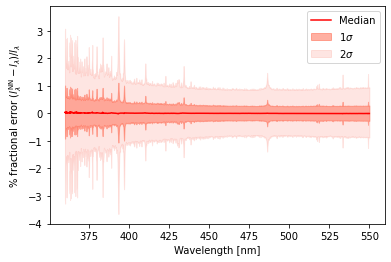

In [31]:
x = wave[wave_bin] / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

# plt.ylim(-5, 5)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

# plt.hlines(0, 200, 1100, ls='--', color='k')
plt.legend()

# plt.xlim(200, 1100)